# Import các thư viện

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
import torch.optim as optim


# Import dữ liệu và tiền xử lý

In [68]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/DXG Historical Data 1_6.csv')

# Nhận thấy tập dữ liệu, ở cột Price giá tiền có dấu phẩy và đang ở dạng string
# Bỏ dấu phẩy
df['Price'] = df['Price'].str.replace(',', '')
# Chuyển sang dạng số
df['Price'] = pd.to_numeric(df['Price'])
df = df[::-1]

In [69]:
df1=df.reset_index()['Price']
df1.head()

0    13401.4
1    13371.1
2    13522.4
3    13159.4
4    14066.9
Name: Price, dtype: float64

In [70]:
df1

0       13401.4
1       13371.1
2       13522.4
3       13159.4
4       14066.9
         ...   
1593    16550.0
1594    16800.0
1595    16850.0
1596    16850.0
1597    16800.0
Name: Price, Length: 1598, dtype: float64

In [71]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [72]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [73]:
test_size

479

In [74]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [75]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train2, y_train2 = create_dataset(train_data, time_step)
X_test2, y_test2 = create_dataset(test_data, time_step)

In [76]:
X_test2.shape

(379, 100)

In [77]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100

x, y = create_dataset(df1, time_step)

X_train = x[:train_size-100]
X_test = x[train_size-100:]
y_train = y[:train_size-100]
y_test = y[train_size-100:]

In [78]:
X_test.shape

(479, 100)

# Tạo Dataset cho PyTorch
Để có thể áp dụng vào model ResNet


In [79]:
# Tạo Dataset cho PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32).unsqueeze(0), torch.tensor(self.y[idx], dtype=torch.float32)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Mô hình ResNET

In [80]:
# Định nghĩa mô hình ResNet
class ConvBlock(Module):
    def __init__(self, ni, nf, ks, stride=1, act=nn.ReLU, act_kwargs={}):
        super().__init__()
        self.conv = nn.Conv1d(ni, nf, ks, stride=stride, padding=ks//2)
        self.bn = nn.BatchNorm1d(nf)
        self.act = act(**act_kwargs) if act is not None else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ResBlock(Module):
    def __init__(self, ni, nf, kss=[7, 5, 3]):
        super().__init__()
        self.convblock1 = ConvBlock(ni, nf, kss[0])
        self.convblock2 = ConvBlock(nf, nf, kss[1])
        self.convblock3 = ConvBlock(nf, nf, kss[2], act=None)

        self.shortcut = nn.BatchNorm1d(ni) if ni == nf else ConvBlock(ni, nf, 1, act=None)
        self.add = nn.Identity()
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.add(x + self.shortcut(res))
        x = self.act(x)
        return x

class ResNet(Module):
    def __init__(self, c_in, c_out, nf=64, kss=[7, 5, 3]):
        super().__init__()
        self.resblock1 = ResBlock(c_in, nf, kss=kss)
        self.resblock2 = ResBlock(nf, nf * 2, kss=kss)
        self.resblock3 = ResBlock(nf * 2, nf * 2, kss=kss)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(nf * 2, c_out)

    def forward(self, x):
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.global_avg_pool(x).squeeze(-1)  # Global Average Pooling to (batch, channels)
        x = self.fc(x)
        return x

In [81]:
# Khởi tạo mô hình
model = ResNet(1, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [82]:
# Huấn luyện mô hình
num_epochs = 120
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Test Loss: {test_loss}')


Epoch 1/120, Loss: 0.01585013046860695, Test Loss: 0.02491966148954816
Epoch 2/120, Loss: 0.00039992580423131585, Test Loss: 0.00913635330653051
Epoch 3/120, Loss: 0.0007553471950814128, Test Loss: 0.007710418460192159
Epoch 4/120, Loss: 0.0034139740746468306, Test Loss: 0.007510667746828403
Epoch 5/120, Loss: 0.0005269975517876446, Test Loss: 0.005996021929604467
Epoch 6/120, Loss: 0.011204151436686516, Test Loss: 0.00757351923675742
Epoch 7/120, Loss: 0.00128084362950176, Test Loss: 0.006093395950301783
Epoch 8/120, Loss: 0.0032433336600661278, Test Loss: 0.005989773962937761
Epoch 9/120, Loss: 0.0008876389474608004, Test Loss: 0.005119669007399352
Epoch 10/120, Loss: 0.000780931324698031, Test Loss: 0.008054279460338876
Epoch 11/120, Loss: 0.00036865155561827123, Test Loss: 0.00796439744590316
Epoch 12/120, Loss: 0.0008258848101831973, Test Loss: 0.00505234105821728
Epoch 13/120, Loss: 0.00025607054703868926, Test Loss: 0.005657191712089116
Epoch 14/120, Loss: 0.0004354307893663645,

# Predict

In [83]:
# Dự báo dữ liệu test
model.eval()
train_predict = []
with torch.no_grad():
    for inputs, _ in train_loader:
        outputs = model(inputs)
        train_predict.extend(outputs.squeeze().numpy())

test_predict = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        test_predict.extend(outputs.squeeze().numpy())

train_predict = scaler.inverse_transform(np.array(train_predict).reshape(-1, 1))
test_predict = scaler.inverse_transform(np.array(test_predict).reshape(-1, 1))

In [84]:
# Dự báo 30 ngày tiếp theo
model.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output = []

for i in range(30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output.extend(yhat.detach().numpy().tolist())

lst_output = scaler.inverse_transform(lst_output)

In [85]:
# Dự báo 60 ngày tiếp theo
model.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_60 = []

for i in range(60):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_60.extend(yhat.detach().numpy().tolist())

lst_output_60 = scaler.inverse_transform(lst_output_60)

In [86]:
# Dự báo 90 ngày tiếp theo
model.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_90 = []

for i in range(90):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_90.extend(yhat.detach().numpy().tolist())

lst_output_90 = scaler.inverse_transform(lst_output_90)

# Các độ đo

In [87]:
# Các độ đo
import numpy as np

# Mean Absolute Error
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Mean Squared Error
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Root Mean Squared Error
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

# Mean Absolute Scaled Error
def mase(y_true, y_pred, y_train):
    n = len(y_train)
    d = np.mean(np.abs(y_train[1:] - y_train[:-1]))
    errors = np.abs(y_true - y_pred)
    return np.mean(errors / d)


In [88]:
# Giá trị thực tế của tập huấn luyện và tập kiểm tra
y_train2 = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test2 = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính độ đo cho tập kiểm tra
test_mae = mae(y_test2, test_predict)
test_mape = mape(y_test2, test_predict)
test_mase = mase(y_test2, test_predict, y_train)
test_mse = mse(y_test2, test_predict)
test_rmse = rmse(y_test2, test_predict)

print(f'Test MAE: {test_mae:.4f}')
print(f'Test MAPE: {test_mape:.4f}%')
print(f'Test MASE: {test_mase:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Test MAE: 890.5134
Test MAPE: 5.7627%
Test MASE: 85458.6935
Test MSE: 1569235.1566
Test RMSE: 1252.6912


# Vẽ hình

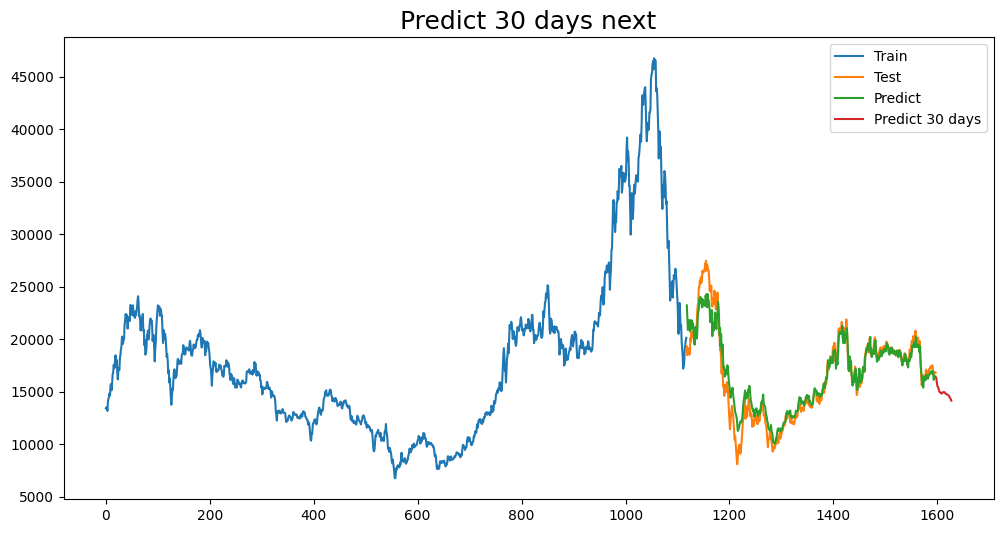

In [89]:
# Vẽ hình
plt.figure(figsize=(12, 6))
plt.title("Predict 30 days next", fontsize=18)
train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step - 100, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index = np.arange(len(df1), len(df1) + 30)
plt.plot(future_data_index, lst_output, label='Predict 30 days')

plt.legend()
plt.show()

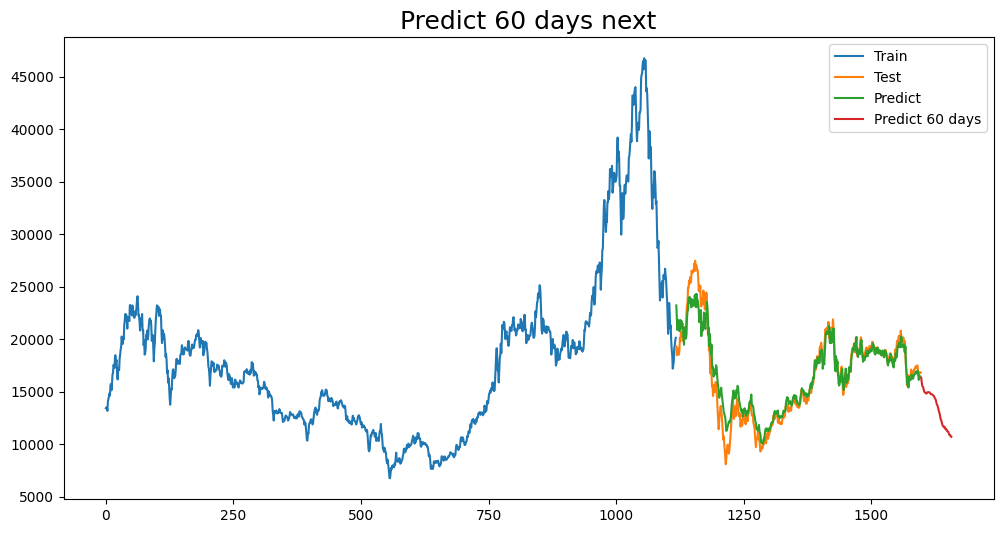

In [90]:
# Vẽ hình
plt.figure(figsize=(12, 6))
plt.title("Predict 60 days next", fontsize=18)
train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step - 100, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index_60 = np.arange(len(df1), len(df1) + 60)
plt.plot(future_data_index_60, lst_output_60, label='Predict 60 days')

plt.legend()
plt.show()

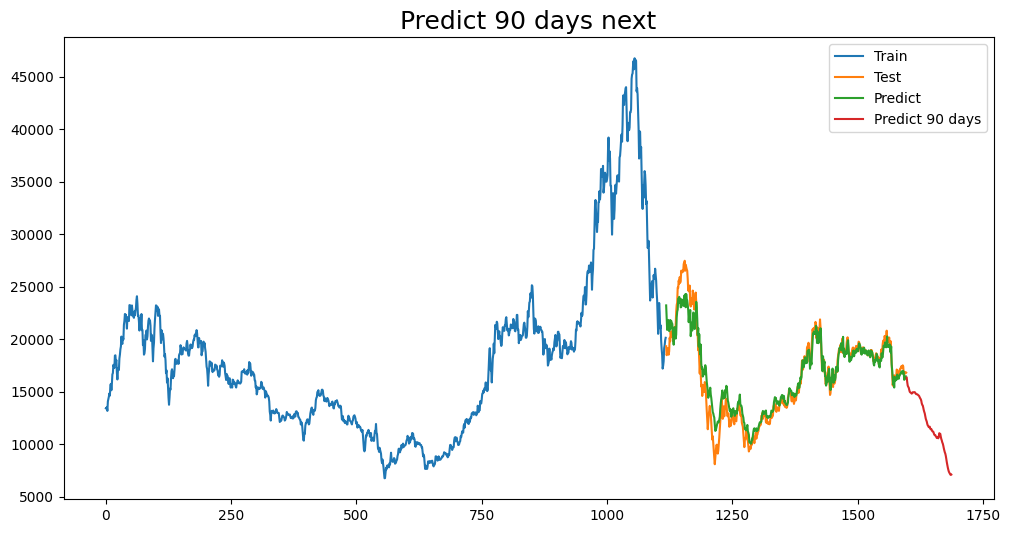

In [91]:
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.title("Predict 90 days next", fontsize=18)

train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step - 100, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index_90 = np.arange(len(df1), len(df1) + 90)
plt.plot(future_data_index_90, lst_output_90, label='Predict 90 days')

plt.legend()
plt.show()

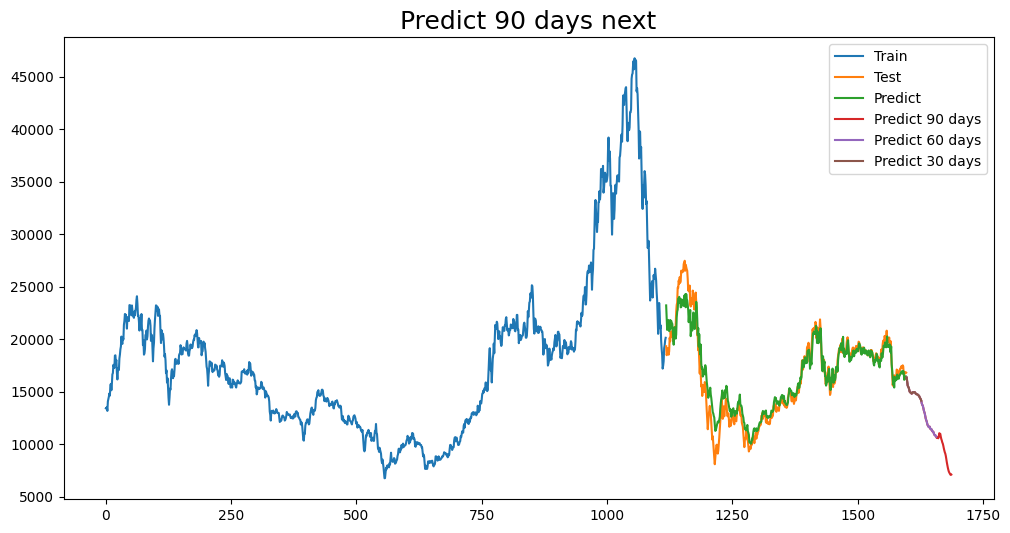

In [92]:
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.title("Predict 90 days next", fontsize=18)

train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step - 100, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index_90 = np.arange(len(df1), len(df1) + 90)
plt.plot(future_data_index_90, lst_output_90, label='Predict 90 days')

future_data_index_60 = np.arange(len(df1), len(df1) + 60)
plt.plot(future_data_index_60, lst_output_60, label='Predict 60 days')


future_data_index = np.arange(len(df1), len(df1) + 30)
plt.plot(future_data_index, lst_output, label='Predict 30 days')

plt.legend()
plt.show()

# Mô hình ResnetLSTM

In [93]:
# Định nghĩa mô hình ResNetLSTM
class ConvBlock(Module):
    def __init__(self, ni, nf, ks, stride=1, act=nn.ReLU, act_kwargs={}):
        super().__init__()
        self.conv = nn.Conv1d(ni, nf, ks, stride=stride, padding=ks//2)
        self.bn = nn.BatchNorm1d(nf)
        self.act = act(**act_kwargs) if act is not None else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ResBlock(Module):
    def __init__(self, ni, nf, kss=[7, 5, 3]):
        super().__init__()
        self.convblock1 = ConvBlock(ni, nf, kss[0])
        self.convblock2 = ConvBlock(nf, nf, kss[1])
        self.convblock3 = ConvBlock(nf, nf, kss[2], act=None)

        self.shortcut = nn.BatchNorm1d(ni) if ni == nf else ConvBlock(ni, nf, 1, act=None)
        self.add = nn.Identity()
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.add(x + self.shortcut(res))
        x = self.act(x)
        return x

class ResNetLSTM(Module):
    def __init__(self, c_in, c_out, lstm_hidden_units=50, num_lstm_layers=1):
        super().__init__()
        nf = 64
        kss = [7, 5, 3]
        self.resblock1 = ResBlock(c_in, nf, kss=kss)
        self.resblock2 = ResBlock(nf, nf * 2, kss=kss)
        self.resblock3 = ResBlock(nf * 2, nf * 2, kss=kss)

        self.lstm = nn.LSTM(nf * 2, lstm_hidden_units, num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_units, c_out)

    def forward(self, x):
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = x.transpose(1, 2)  # Transpose for LSTM: (batch, channels, seq_len) -> (batch, seq_len, channels)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Lấy đầu ra của LSTM ở bước thời gian cuối cùng
        x = self.fc(x)
        return x

In [94]:
# Khởi tạo mô hình
model2 = ResNetLSTM(1, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

In [95]:
# Huấn luyện mô hình
num_epochs = 100
for epoch in range(num_epochs):
    model2.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    model2.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model2(inputs)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Test Loss: {test_loss}')


Epoch 1/100, Loss: 0.05158704146742821, Test Loss: 0.06266949401469901
Epoch 2/100, Loss: 0.011361506767570972, Test Loss: 0.017576051657670178
Epoch 3/100, Loss: 0.002503433730453253, Test Loss: 0.003935577355150599
Epoch 4/100, Loss: 0.0005209752125665545, Test Loss: 0.0009085357778531034
Epoch 5/100, Loss: 0.00024648383259773254, Test Loss: 0.0003338016013003653
Epoch 6/100, Loss: 0.0002829414152074605, Test Loss: 0.0003151701539536589
Epoch 7/100, Loss: 0.00029409717535600066, Test Loss: 0.00031438730457011843
Epoch 8/100, Loss: 0.00025175162591040134, Test Loss: 0.00027451361074781744
Epoch 9/100, Loss: 0.00020358951587695628, Test Loss: 0.0002482575728208758
Epoch 10/100, Loss: 0.0004944668035022914, Test Loss: 0.0005729904114559758
Epoch 11/100, Loss: 0.00020104330906178802, Test Loss: 0.0002483924999978626
Epoch 12/100, Loss: 0.00023845983378123492, Test Loss: 0.00026550381971901515
Epoch 13/100, Loss: 0.0002316871687071398, Test Loss: 0.0002760302977549145
Epoch 14/100, Loss: 

In [96]:
# Dự báo dữ liệu test
model2.eval()
train_predict = []
with torch.no_grad():
    for inputs, _ in train_loader:
        outputs = model2(inputs)
        train_predict.extend(outputs.squeeze().numpy())

test_predict = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model2(inputs)
        test_predict.extend(outputs.squeeze().numpy())

train_predict = scaler.inverse_transform(np.array(train_predict).reshape(-1, 1))
test_predict = scaler.inverse_transform(np.array(test_predict).reshape(-1, 1))

In [97]:
# Giá trị thực tế của tập huấn luyện và tập kiểm tra
y_train2 = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test2 = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính độ đo cho tập kiểm tra
test_mae = mae(y_test2, test_predict)
test_mape = mape(y_test2, test_predict)
test_mase = mase(y_test2, test_predict, y_train)
test_mse = mse(y_test2, test_predict)
test_rmse = rmse(y_test2, test_predict)

print(f'Test MAE: {test_mae:.4f}')
print(f'Test MAPE: {test_mape:.4f}%')
print(f'Test MASE: {test_mase:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Test MAE: 543.5851
Test MAPE: 3.3779%
Test MASE: 52165.4929
Test MSE: 477548.7335
Test RMSE: 691.0490


In [98]:
# Dự báo 90 ngày tiếp theo
model2.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_90 = []

for i in range(90):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model2(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model2(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_90.extend(yhat.detach().numpy().tolist())

lst_output_90 = scaler.inverse_transform(lst_output_90)

In [99]:
# Dự báo 60 ngày tiếp theo
model2.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_60 = []

for i in range(60):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model2(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model2(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_60.extend(yhat.detach().numpy().tolist())

lst_output_60 = scaler.inverse_transform(lst_output_60)

In [100]:
# Dự báo 30 ngày tiếp theo
model2.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_30 = []

for i in range(30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model2(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_30.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model2(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_30.extend(yhat.detach().numpy().tolist())

lst_output_30 = scaler.inverse_transform(lst_output_30)

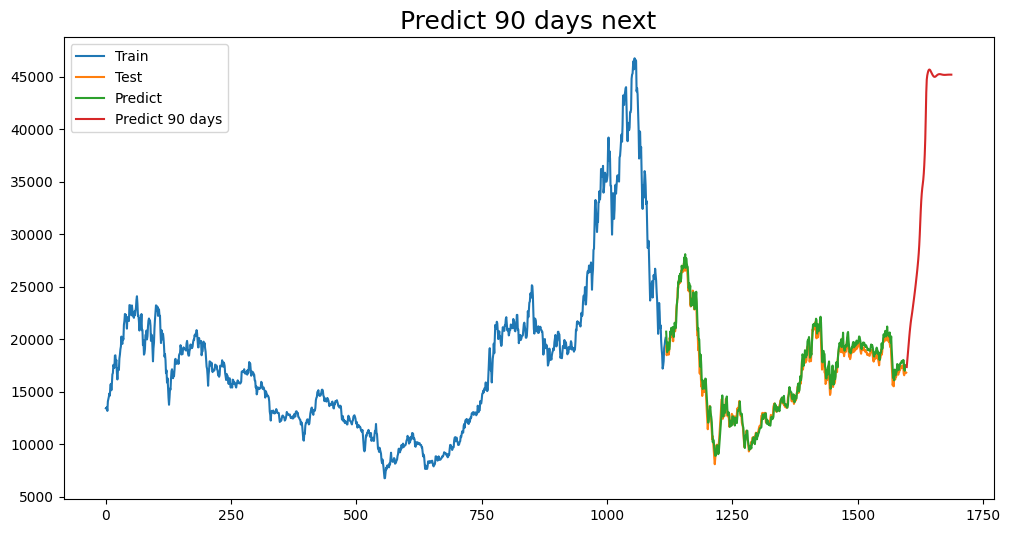

In [101]:
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.title("Predict 90 days next", fontsize=18)

train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step - 100, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index_90 = np.arange(len(df1), len(df1) + 90)
plt.plot(future_data_index_90, lst_output_90, label='Predict 90 days')

plt.legend()
plt.show()

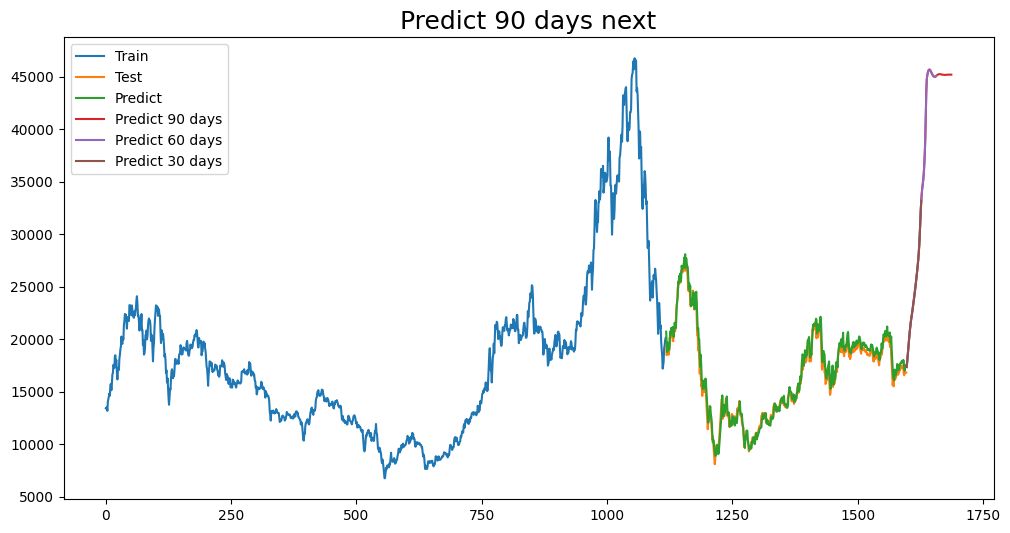

In [102]:
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.title("Predict 90 days next", fontsize=18)

train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step - 100, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index_90 = np.arange(len(df1), len(df1) + 90)
plt.plot(future_data_index_90, lst_output_90, label='Predict 90 days')

future_data_index_60 = np.arange(len(df1), len(df1) + 60)
plt.plot(future_data_index_60, lst_output_60, label='Predict 60 days')


future_data_index30 = np.arange(len(df1), len(df1) + 30)
plt.plot(future_data_index30, lst_output_30, label='Predict 30 days')

plt.legend()
plt.show()